In [14]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Time to get cooking! You are optimising a cake recipe. There are five ingredients. The outputs correspond to the sum of different objectives: flavor, consistency, calories, waste and cost. Each objective receives negative points by our expert taster. You want this sum to be as close to zero as possible!

In [15]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_6/initial_inputs.npy',
    '../initial_data/function_6/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_6/initial_inputs.npy',
    '../initial_data2/function_6/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


,x1,x2,x3,x4,x5,y
0,0.728186,0.154693,0.732552,0.693997,0.056401,-0.714265
1,0.242384,0.844100,0.577809,0.679021,0.501953,-1.209955
2,0.729523,0.748106,0.679775,0.356552,0.671054,-1.672200
3,0.770620,0.114404,0.046780,0.648324,0.273549,-1.536058
4,0.618812,0.331802,0.187288,0.756238,0.328835,-0.829237


In [16]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f6', 'f6_output']]
df_feedback['f6'] = df_feedback['f6'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f6'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f6'].apply(lambda x: float(x[i]))

df_feedback.drop('f6', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f6_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'x3', 'x4', 'x5', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

,x1,x2,x3,x4,x5,y
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.557029,0.528703,0.389260,0.445552,0.523475,-1.763204
std,0.322669,0.332257,0.326486,0.308434,0.331949,0.729756
min,0.000000,0.000000,0.000000,0.000000,0.004911,-3.509376
25%,0.250645,0.276069,0.055654,0.175036,0.245192,-1.960407
50%,0.618812,0.531916,0.359416,0.474904,0.522528,-1.672200
75%,0.817996,0.835191,0.671741,0.699498,0.775205,-1.240418
max,0.999999,0.999999,0.996195,0.965947,0.999999,-0.714265


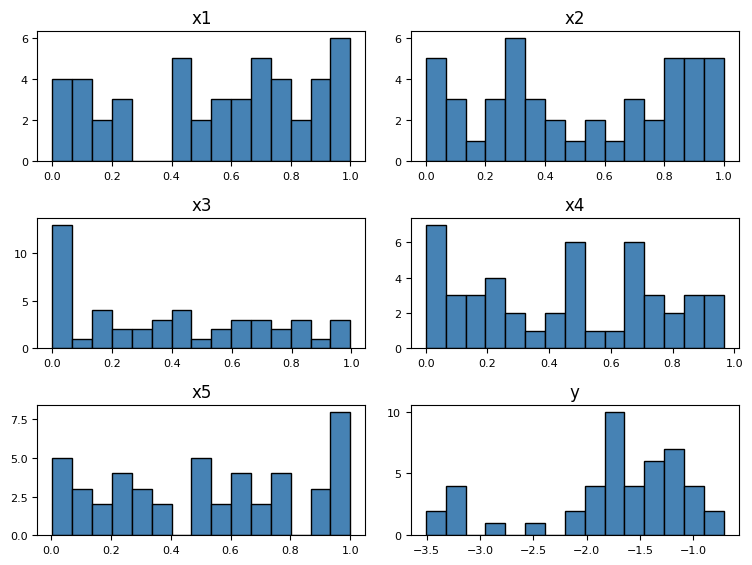

In [17]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [18]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


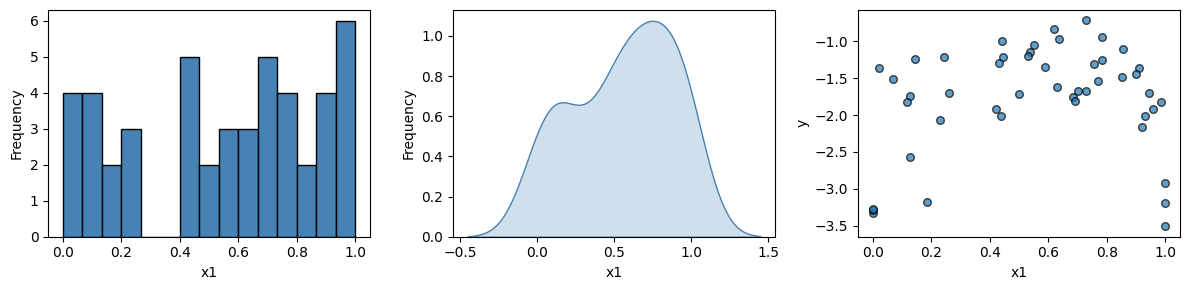

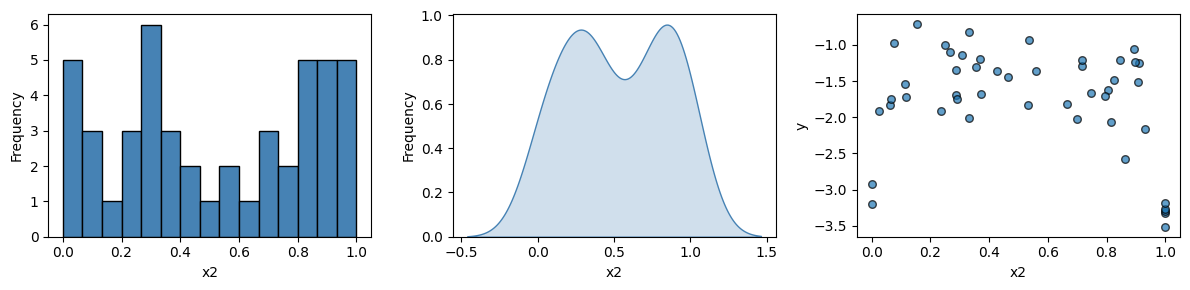

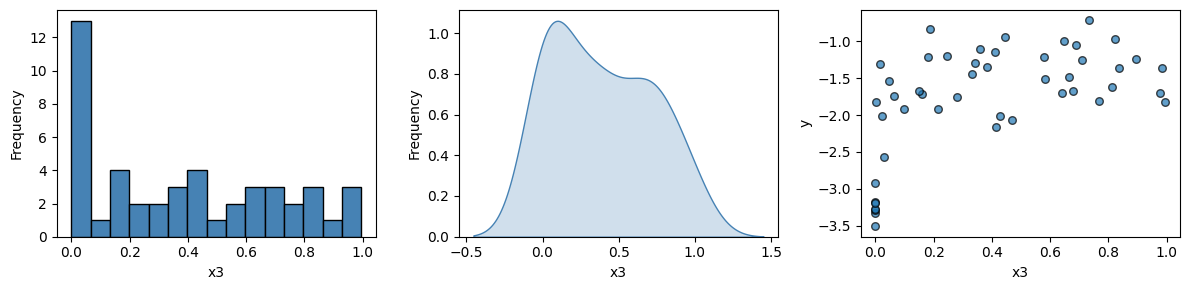

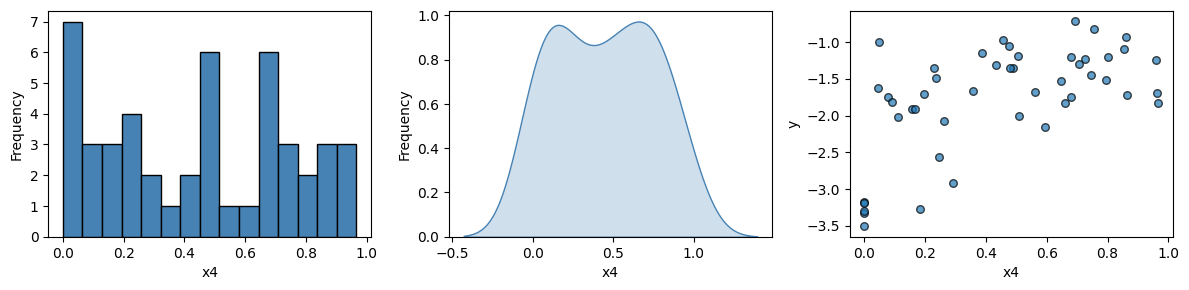

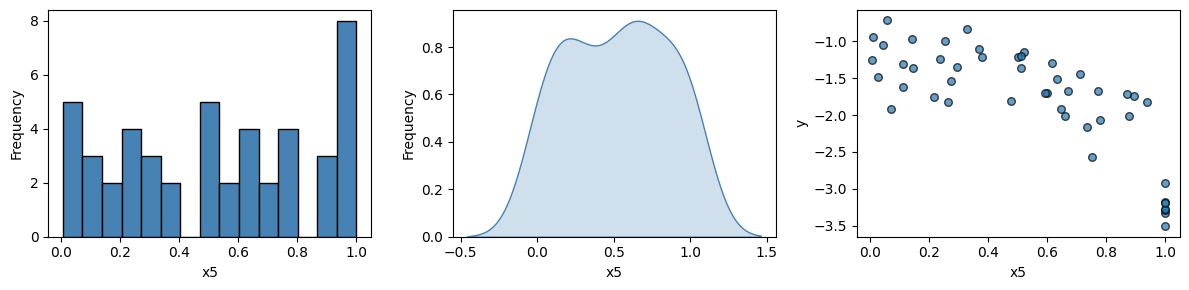

In [19]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')
analyse_param(df, 'x3', 'y')
analyse_param(df, 'x4', 'y')
analyse_param(df, 'x5', 'y')

In [20]:
def analyse_corr_to_y(df):
    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm')

    # Analyse correlation of variables to y
    g = sns.PairGrid(df, y_vars=["y"], x_vars=["x1", "x2", "x3", "x4", "x5"])
    g.map(sns.regplot, color='steelblue')

    plt.tight_layout()
    plt.show()

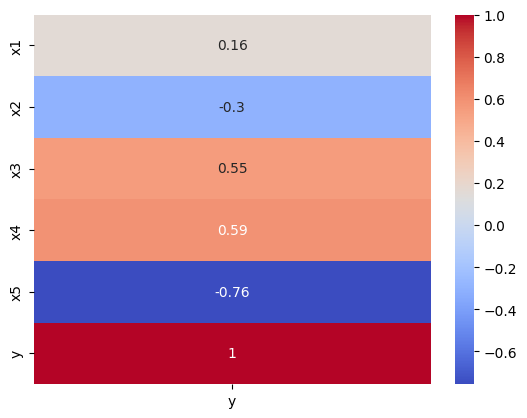

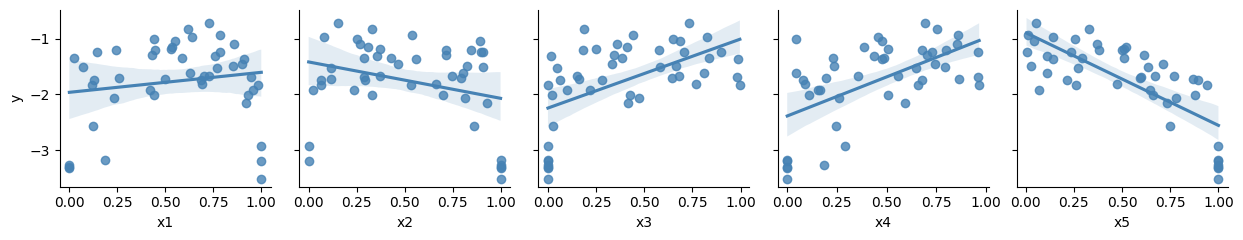

In [21]:
analyse_corr_to_y(df)

In [22]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

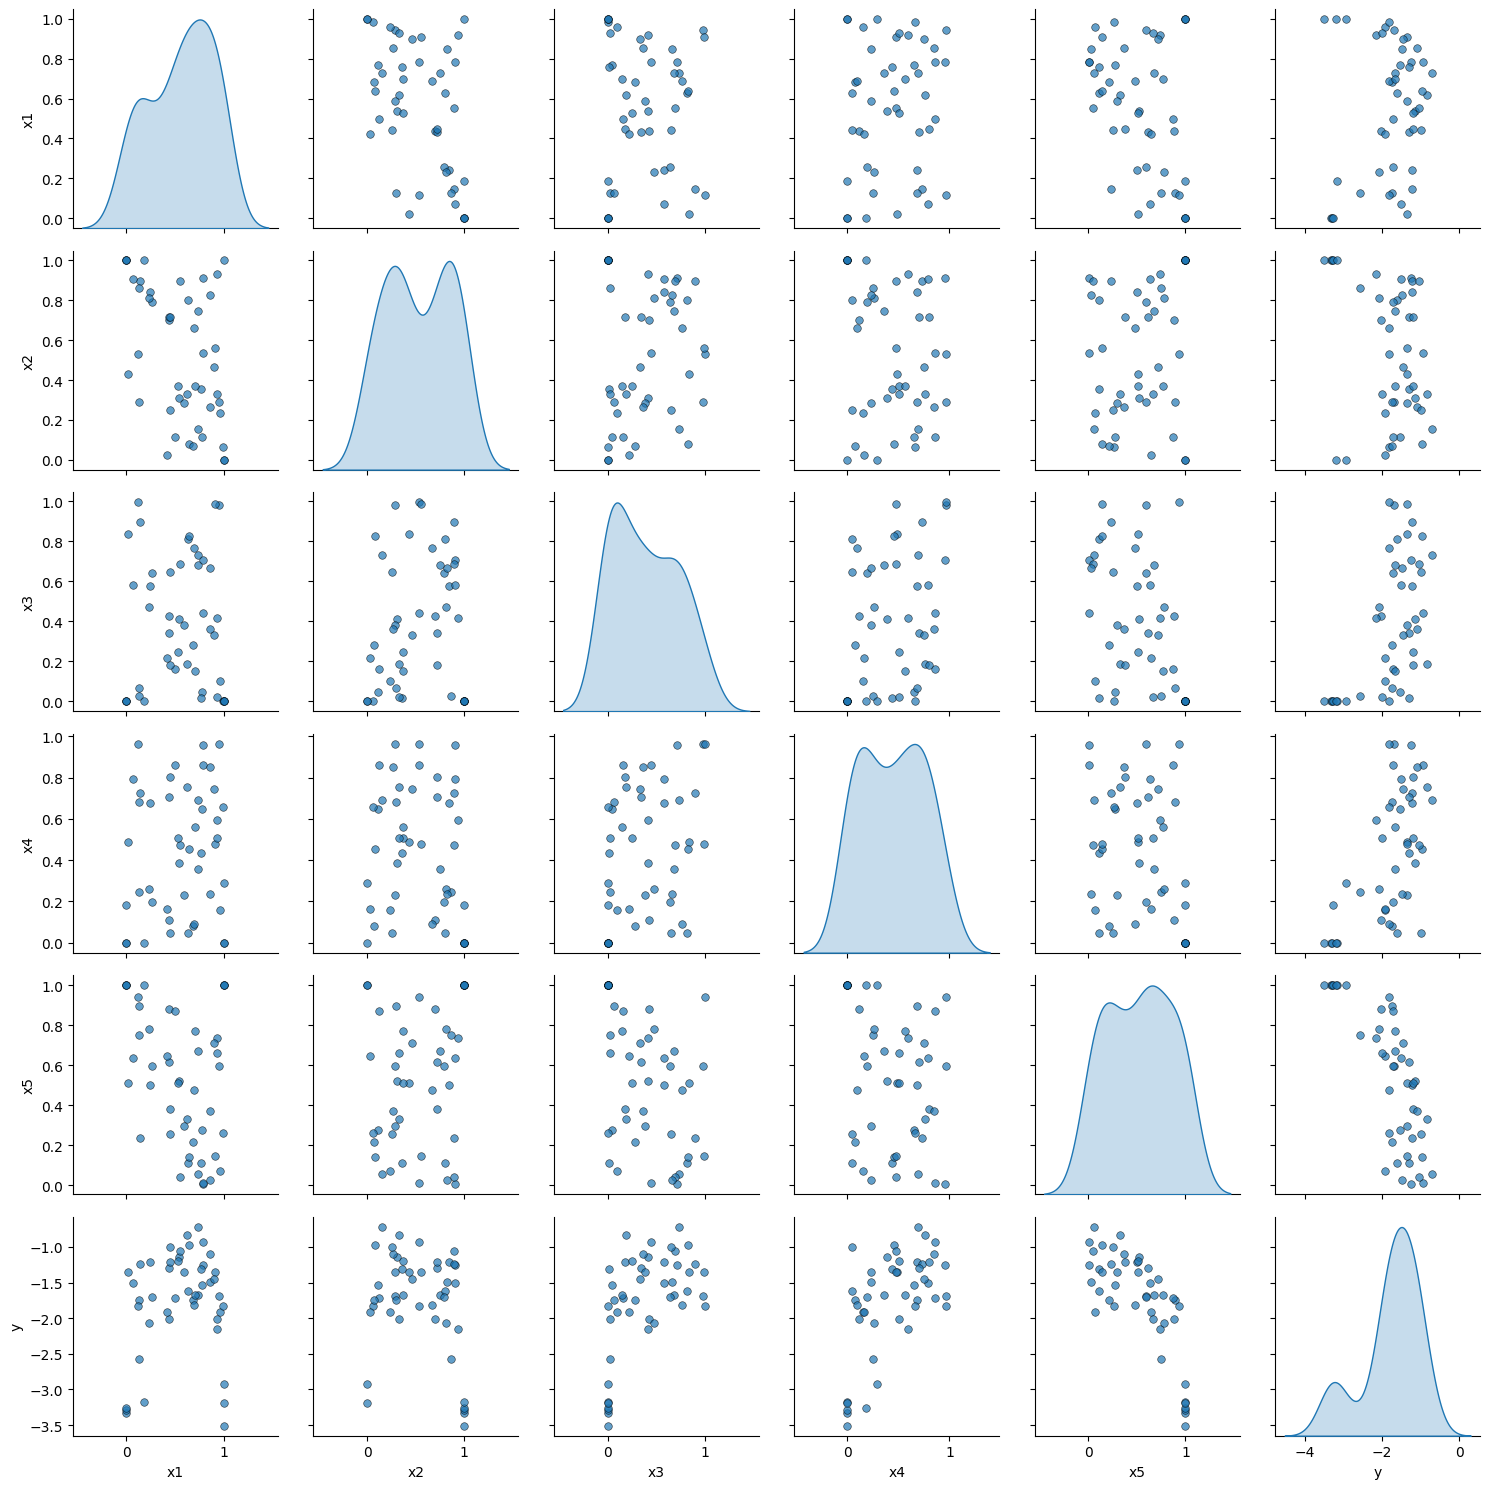

In [23]:
pairwise_relationship(df)

In [24]:
def objective_fn(x):
    return np.abs([x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3] + x[:, 4]])

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x4', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x5', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.RBF(
    input_dim=5,
    variance=1.0,
    lengthscale=1.0,
    ARD=False
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=5,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 40)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2', 'x3', 'x4', 'x5']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

In [25]:
bo.plot_acquisition()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
